### Задачи

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5.1. Выполните когортный анализ пользователей.

5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из 8-го урока python, раздел “Стильный урок”, степ 5.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

### Данные

#### customers -  таблица с уникальными идентификаторами пользователей

Столбцы:

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

#### orders - таблица заказов

Столбцы:

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

#### products - товарные позиции, входящие в заказы

Столбцы:

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlencode
import requests

from datetime import timedelta

sns.set(rc={"figure.figsize": (8, 6)})

Считаем данные

In [2]:
def down_df(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    
    return download_url

public_key_1 = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
customers = pd.read_csv(down_df(public_key_1))

public_key_2 = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
orders = pd.read_csv(down_df(public_key_2))

public_key_3 = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'
products = pd.read_csv(down_df(public_key_3))

Проведем разведочный анализ(EDA)

Начнем с таблицы с информацией о пользователях

In [3]:
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [5]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
customers.duplicated().sum()

0

In [7]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Количество уникальных клиентов составляет 96096. В даннных нет пропуской и дуюликатов, тип данных соответствует заявленным

Посмотрим на таблицу с заказами

In [8]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [10]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Переведем столбцы с датами к типу datetime

In [11]:
columns_to_convert = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[columns_to_convert] = orders[columns_to_convert].apply(pd.to_datetime)

Как мы могли заметить, в некоторых столбцах есть пропуски, сейчас попробуем их обыяснить

Посмотрим на промежуток времени за который взяты данные

In [12]:
orders.agg({'order_purchase_timestamp': ['min', 'max'],
           'order_approved_at': ['min', 'max'],
           'order_delivered_carrier_date': ['min', 'max'],
           'order_delivered_customer_date': ['min', 'max'],
           'order_estimated_delivery_date': ['min', 'max']})


,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12


Посмотрим на столбец order_approved_at                 

In [13]:
orders.loc[orders['order_approved_at'].isnull()].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30


In [14]:
orders.loc[orders['order_approved_at'].isnull()].groupby('order_status').size()

order_status
canceled     141
created        5
delivered     14
dtype: int64

In [15]:
orders.loc[orders['order_delivered_carrier_date'].isnull()].groupby('order_status').size()

order_status
approved         2
canceled       550
created          5
delivered        2
invoiced       314
processing     301
unavailable    609
dtype: int64

Большинство заказов без даты относится к категоиии отмен, недоступных, что вполне нормально. 

In [16]:
orders.duplicated().sum()

0

In [17]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

Количество заказов составляет 99441. В даннных нет дубликатов, некоторые столбцы перевели в нужный формат, также в таблице имеются пропущенные значения.

Посмотрим на таблицу с товарными позициями, входящими в заказ

In [18]:
products.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [19]:
products.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Переведем столбец с датой к удобному формату

In [20]:
products.shipping_limit_date = pd.to_datetime(products.shipping_limit_date)

In [21]:
products.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [22]:
products.duplicated().sum()

0

In [23]:
products.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [24]:
products.price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

In [25]:
price_products = products.query('price < 900').groupby('price', as_index=False).agg({'order_id' : 'count'})
price_products.head()

,price,order_id
0,0.85,3
1,1.20,20
2,2.20,1
3,2.29,1
4,2.90,1


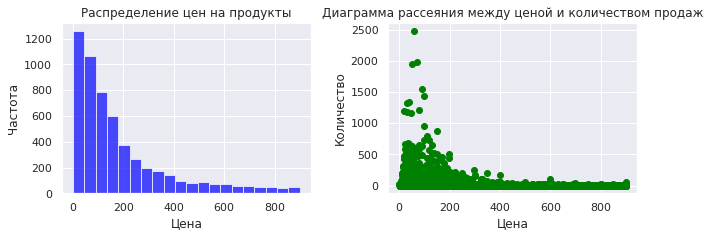

In [26]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.hist(price_products['price'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Распределение цен на продукты')

plt.subplot(2, 2, 2)
plt.scatter(price_products['price'], price_products['order_id'], color='green')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('Диаграмма рассеяния между ценой и количеством продаж')


plt.tight_layout()
plt.show()

In [27]:
products.price.quantile(0.99)

890.0

In [28]:
products.price.quantile(0.5)

74.99

Количество уникальных заказов составляет 98666. Также 99% товаров не превышают 890 у е, a 50% всех товаров стоят меньше 75 у е

Приступим к решению вопросов.

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Сформулируем, что будет считаться покупкой

Это заказ, который не является:
    1. отменным (canceled)
    2. недоступным (unavailable)
    3. созданным (created)

In [29]:
orders_success = orders.query('order_status not in ["canceled", "unavailable", "created"]')

In [30]:
customers_success = customers.merge(orders_success, on='customer_id', how='right')

In [31]:
customers_success.groupby('customer_unique_id', as_index=False).agg({'order_status' : 'count'}).query('order_status == 1').shape

(92099, 2)

92099 совершили покупку только один раз



# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Заказ может быть не доставлен, если он имеет статус canceled или unavailable

In [32]:
undeliver_orders = orders.query("order_status in ('canceled', 'unavailable')")

In [33]:
undeliver_orders['order_estimated_delivery_month'] = undeliver_orders['order_estimated_delivery_date'].dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
undeliver_orders_pivot = undeliver_orders \
    .groupby(['order_estimated_delivery_month', 'order_status'], as_index=False) \
    .agg({'order_id' : 'count'}) \
    .pivot(index='order_estimated_delivery_month', columns='order_status', values='order_id')
undeliver_orders_pivot.head(4)

order_status,canceled,unavailable
order_estimated_delivery_month,,
2016-09,1.0,NaN
2016-10,3.0,NaN
2016-11,14.0,5.0
2016-12,8.0,2.0


In [35]:
mean_canceled = undeliver_orders_pivot.canceled.mean().astype(int)
mean_unavailable = undeliver_orders_pivot.unavailable.mean().astype(int)
print(f'{mean_canceled} заказа в месяц не доставляется по причине отмены')
print(f'{mean_unavailable} заказов в месяц не доставляется по причине недоступности')

24 заказа в месяц не доставляется по причине отмены
29 заказов в месяц не доставляется по причине недоступности


# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.



In [36]:
top_weekday_item = customers_success[['customer_unique_id', 'order_id','order_purchase_timestamp']].merge(products, on='order_id', how='left')

In [37]:
top_weekday_item.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


Сделаем новый столбец с днем недели

In [38]:
top_weekday_item['weekday'] = top_weekday_item.order_purchase_timestamp.dt.weekday

Создадим таблицу с информацией о количестве продаж продукта в определенный день недели

In [39]:
top_weekday_item = top_weekday_item.groupby(['product_id', 'weekday'], as_index=False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns={'customer_unique_id' : 'quantity'})
top_weekday_item.head(3)

,product_id,weekday,quantity
0,00066f42aeeb9f3007548bb9d3f33c38,6,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,3,1


In [40]:
top_weekday_item.weekday = top_weekday_item.weekday.replace({0: 'понедельник', 1: 'вторник', 2: 'среда', 3: 'четверг', 4: 'пятница', 5: 'суббота', 6: 'воскресенье'})

Создадим таблицу с информацией о максимальном количестве продаж за день и объединим с нашей таблицей, а после отсортируем дни недели, где количество пролаж не ровняется максимальному

In [41]:
max_item = top_weekday_item.groupby('product_id', as_index=False) \
    .agg({'quantity' : 'max'}) \
    .sort_values('quantity', ascending=False)


In [42]:
top_weekday_for_items = top_weekday_item.merge(max_item, on='product_id', how='left') \
    .query('quantity_y == quantity_x') \
    .drop('quantity_y', axis=1) \
    .sort_values('quantity_x', ascending=False)

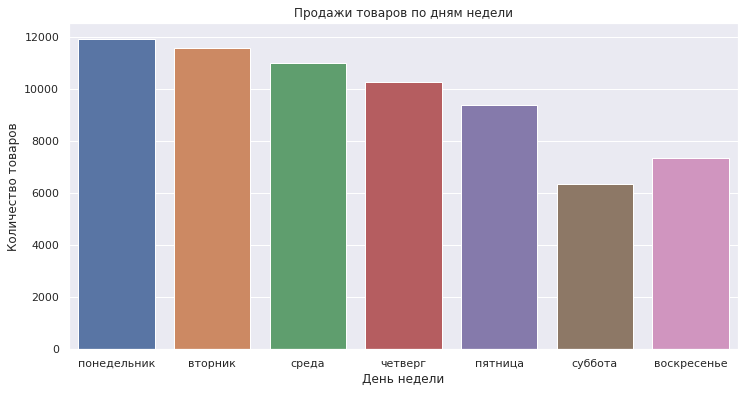

In [43]:
plt.figure(figsize=(12, 6))

sns.barplot(data=top_weekday_for_items.groupby('weekday', as_index=False).agg({'quantity_x' : 'sum'}),
            x='weekday', y='quantity_x', order=['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])

plt.title('Продажи товаров по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество товаров')

plt.show()


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [44]:
customers_success.agg({'order_purchase_timestamp' : ['min', 'max']})

,order_purchase_timestamp
min,2016-09-04 21:15:19
max,2018-09-03 09:06:57


Так как первый и последний месяц неполный - уберем их

In [45]:
customers_success = customers_success.query('order_purchase_timestamp >= "2016-10-01" and order_purchase_timestamp < "2018-09-01"') 

Создадим столбец где будет хроониться информация о месяце создания заказа

In [46]:
customers_success['order_purchase_month'] = customers_success['order_purchase_timestamp'].dt.to_period('M')

Посчитаем сколько заказов сделал пользователь за каждый месяц

In [47]:
week_customers = customers_success.groupby(['customer_unique_id', 'order_purchase_month'], as_index=False) \
    .agg({'customer_id' : 'count'}) \
    .rename(columns={'customer_id' : 'quantity'})

week_customers

,customer_unique_id,order_purchase_month,quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1
...,...,...,...
96856,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1
96857,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1
96858,ffff371b4d645b6ecea244b27531430a,2017-02,1
96859,ffff5962728ec6157033ef9805bacc48,2018-05,1


Посчитаем количество недель для каждого месяца

In [48]:
week_customers['days_in_month'] = week_customers.order_purchase_month.dt.days_in_month
week_customers.head()

,customer_unique_id,order_purchase_month,quantity,days_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31
2,0000f46a3911fa3c0805444483337064,2017-03,1,31
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,31
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30


Посчитаем количество недель для каждого месяца 


In [49]:
week_customers['number_of_weeks'] = week_customers['days_in_month'] / 7
week_customers.head()

,customer_unique_id,order_purchase_month,quantity,days_in_month,number_of_weeks
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03,1,31,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,31,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30,4.285714


Посчитаем среднее число покупок в неделю по месяцам

In [50]:
week_customers['purchases_avg'] = week_customers.quantity / week_customers.number_of_weeks
week_customers = week_customers[['customer_unique_id', 'order_purchase_month', 'purchases_avg']]

In [51]:
week_customers.head()

,customer_unique_id,order_purchase_month,purchases_avg
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333


In [52]:
week_customers.purchases_avg.describe()

count    96861.000000
mean         0.233363
std          0.029474
min          0.225806
25%          0.225806
50%          0.225806
75%          0.233333
max          1.354839
Name: purchases_avg, dtype: float64

In [53]:
week_customers.purchases_avg.quantile(1)

1.3548387096774193

In [54]:
print(f'В среднем каждый пользователь делает 0.22 заказа в неделю или примерно 1 заказ в месяц')
print(f'99% всех наблюдений лежит в диапозоне {np.round(week_customers.purchases_avg.quantile(0.99), 5)} и {np.round(week_customers.purchases_avg.quantile(1), 5)}')

В среднем каждый пользователь делает 0.22 заказа в неделю или примерно 1 заказ в месяц
99% всех наблюдений лежит в диапозоне 0.45161 и 1.35484


### 5.1. Выполните когортный анализ пользователей.



### 5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

Возьмем созданныую ранее таблицу с успешными покупками пользователей

In [55]:
customers_success.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08


Добавим месяц первой покупки пользователя

In [56]:
first_push_customers = customers_success.groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp' : 'min'}) \
    .rename(columns={'order_purchase_timestamp' : 'first_date_push'})
first_push_customers.head()

,customer_unique_id,first_date_push
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [57]:
cohort_df = customers_success.merge(first_push_customers, on='customer_unique_id')

Определяем когорты в зависимости от месяца первой покупки

In [58]:
cohort_df['cohort'] = cohort_df.first_date_push.dt.to_period('M')
cohort_df['cohort_period'] = (cohort_df.order_purchase_timestamp.dt.month - cohort_df.cohort.dt.month) + 12 * (cohort_df.order_purchase_timestamp.dt.year - cohort_df.cohort.dt.year)

In [59]:
orders.agg({'order_purchase_timestamp': ['min', 'max'],
           'order_approved_at': ['min', 'max'],
           'order_delivered_carrier_date': ['min', 'max'],
           'order_delivered_customer_date': ['min', 'max'],
           'order_estimated_delivery_date': ['min', 'max']})


,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12


Так как нам нужны данные за полный год(янв-дек), возьмем 2017 год

In [60]:
cohort_analysis = cohort_df.query('first_date_push.dt.year == 2017 ')

In [61]:
cohort_analysis = cohort_analysis.groupby(['cohort', 'cohort_period'], as_index=False) \
    .agg({'customer_unique_id' : 'nunique'})

In [62]:
cohort_analysis = cohort_analysis.pivot(index='cohort', columns='cohort_period', values='customer_unique_id')

In [63]:
cohort_analysis

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,752.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1690.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2325.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,3.0,NaN,NaN
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,8.0,NaN,NaN,NaN
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07,3822.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08,4130.0,28.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4075.0,28.0,22.0,12.0,18.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Считаем retention

In [64]:
cohort_analysis = cohort_analysis.apply(lambda x: x / cohort_analysis[0])

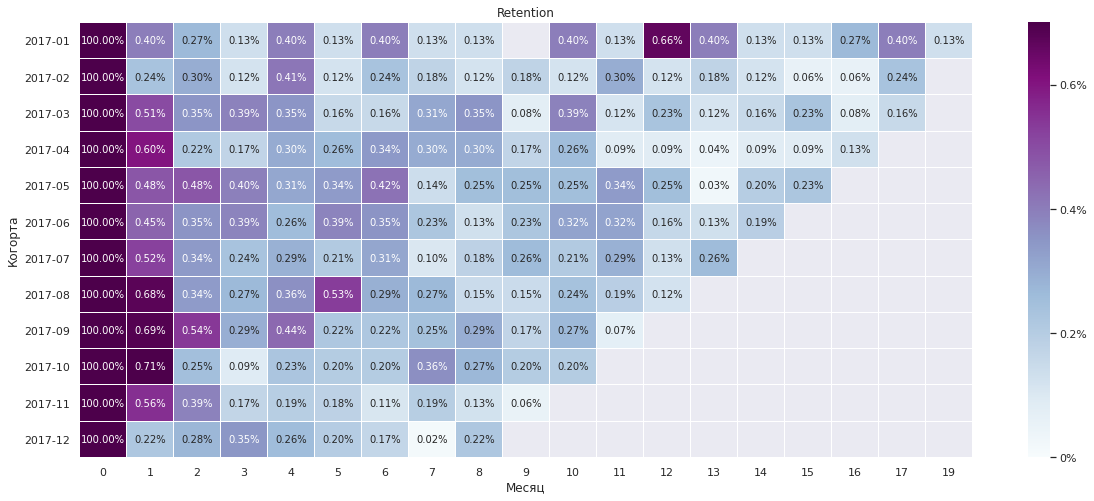

In [65]:
plt.figure(figsize=(20, 8))
heatmap  = sns.heatmap(cohort_analysis, annot=True, annot_kws={"fontsize":10}, cmap='BuPu', fmt='.2%', vmin=0.0, vmax=0.007, linewidths=0.01)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 0.002, 0.004, 0.006, 0.008])  # Установите нужные значения
cbar.set_ticklabels(['0%', '0.2%', '0.4%', '0.6%', '0.8%']) 

plt.title('Retention')
plt.xlabel('Месяц')
plt.ylabel('Когорта')
plt.show()

 Максимальный Retention на третий месяц был в мае 2017 года и составлял 0.40%

#### 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

Для построения RFM-сегментации пользователей необходимы данные с клиенте, времени  и сумме заказа.

In [66]:
rfm_df = customers \
    .merge(orders, on = 'customer_id') \
    .merge(products, on = 'order_id')
rfm_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


Определим дату для подсчета recency. Это будет дата последней доставки плюс 1 день.

In [67]:
now = rfm_df.order_delivered_customer_date.max() + timedelta(days=1)
now

Timestamp('2018-10-18 13:22:46')

Период данных для RFM сегментации возьмем в 1 год

In [68]:
period = 365

### Расситываем Recency для каждого кллиента

Добавляем столбец с количеством дней между покупкой и now

In [69]:
rfm_df['DaysSinceOrder'] =  rfm_df['order_purchase_timestamp'].apply(lambda x: (now - x).days)

In [70]:
rfm_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,DaysSinceOrder
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,519
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,278
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,151
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,218
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,81


Cчитаем RFM

In [125]:
rfm = rfm_df.groupby('customer_unique_id', as_index=False) \
    .agg({'DaysSinceOrder' : 'min',
         'order_id' : 'nunique',
         'price' : 'sum'}) \
    .rename(columns={'DaysSinceOrder' : 'Recency',
                    'order_id' : 'Frequency',
                    'price' : 'Monetary'})

In [123]:
rfm.head(4)

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90
2,0000f46a3911fa3c0805444483337064,586,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99


Рассчитаем баллы R, F и M


Каждый клиент получит от 1 до 5 для каждого параметра. Для распределения используем метод квинтилей.

In [73]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 142.0, 0.4: 227.0, 0.6: 318.0, 0.8: 433.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Большинство пользователей совершает 1 покупку, поэтому опредлелять разбаловку Frequency будем другим методом.

In [74]:
rfm.Frequency.value_counts() 

1     92507
2      2673
3       192
4        29
5         9
6         5
7         3
16        1
9         1
Name: Frequency, dtype: int64

In [75]:
quintiles['Frequency'] = {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 4.0} 
quintiles

{'Recency': {0.2: 142.0, 0.4: 227.0, 0.6: 318.0, 0.8: 433.0},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 4.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Также посмотрим подробнее повнимательнее на давность покупки

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


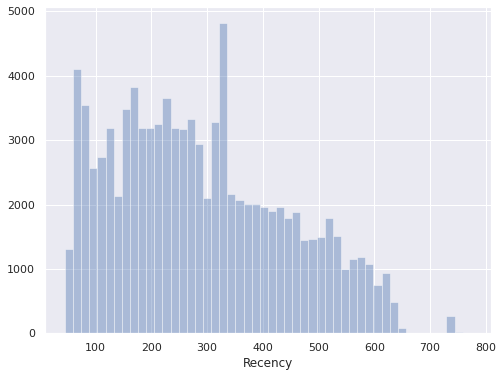

In [130]:
sns.distplot(rfm.Recency, kde = False)

Можно заметить, что для большинства клиентов прошло достаточно продолжительное время после последнего заказа.

In [76]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [77]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [78]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,4,1,1
2,0000f46a3911fa3c0805444483337064,586,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,337,1,180.00,2,1,5


Получим сегмент клиента

In [79]:
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,586,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,337,1,180.00,2,1,5,215


In [80]:
rfm.groupby('RFM_Score', as_index=False).agg({'Recency' : 'count'})

,RFM_Score,Recency
0,111,4158
1,112,4020
2,113,3453
3,114,3304
4,115,3613
...,...,...
75,533,6
76,534,4
77,535,36
78,545,13


In [81]:
segt_map = {
    r'[1-2][1-2]': 'спящие',
    r'[1-2][3-4]': 'в зоне риска',
    r'[1-2]5': 'нельзя терять',
    r'3[1-2]': 'почти уснули',
    r'33': 'требуют внимания',
    r'[3-4][4-5]': 'лояльные',
    r'41': 'подающие надежду',
    r'51': 'новички',
    r'[4-5][2-3]': 'потенциальные  лояльные',
    r'5[4-5]': 'чемпионы'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90,4,1,4,414,подающие надежду
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,4,1,1,411,подающие надежду
2,0000f46a3911fa3c0805444483337064,586,1,69.00,1,1,2,112,спящие
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,2,1,1,211,спящие
4,0004aac84e0df4da2b147fca70cf8255,337,1,180.00,2,1,5,215,спящие


In [82]:
segment_count = rfm.groupby('Segment', as_index=False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns={'customer_unique_id' : 'quantity'}) \
    .sort_values('quantity', ascending=False)
segment_count

,Segment,quantity
7,спящие,37850
6,почти уснули,19080
4,подающие надежду,18602
3,новички,18516
5,потенциальные лояльные,1229
0,в зоне риска,71
8,требуют внимания,31
9,чемпионы,21
1,лояльные,19
2,нельзя терять,1


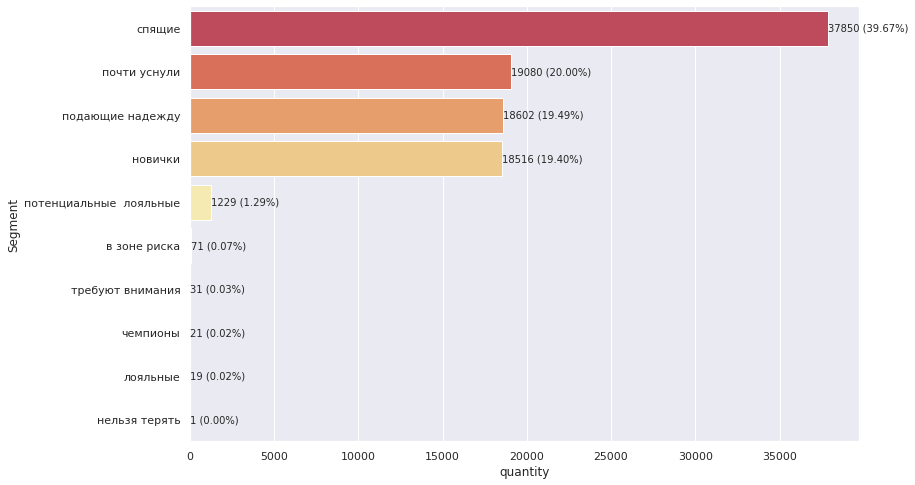

In [107]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=segment_count, x='quantity', y='Segment', palette='Spectral')

for index, value in enumerate(segment_count['quantity']):
    total_quantity = sum(segment_count.quantity)
    percentage = (value / total_quantity) * 100
    ax.text(value, index, f'{value} ({percentage:.2f}%)', ha='left', va='center', fontsize=10)

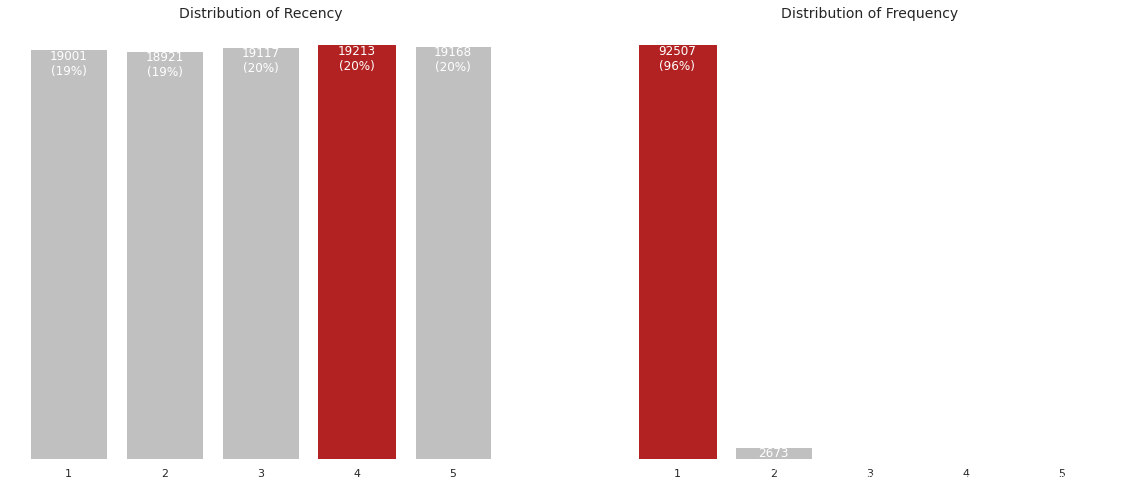

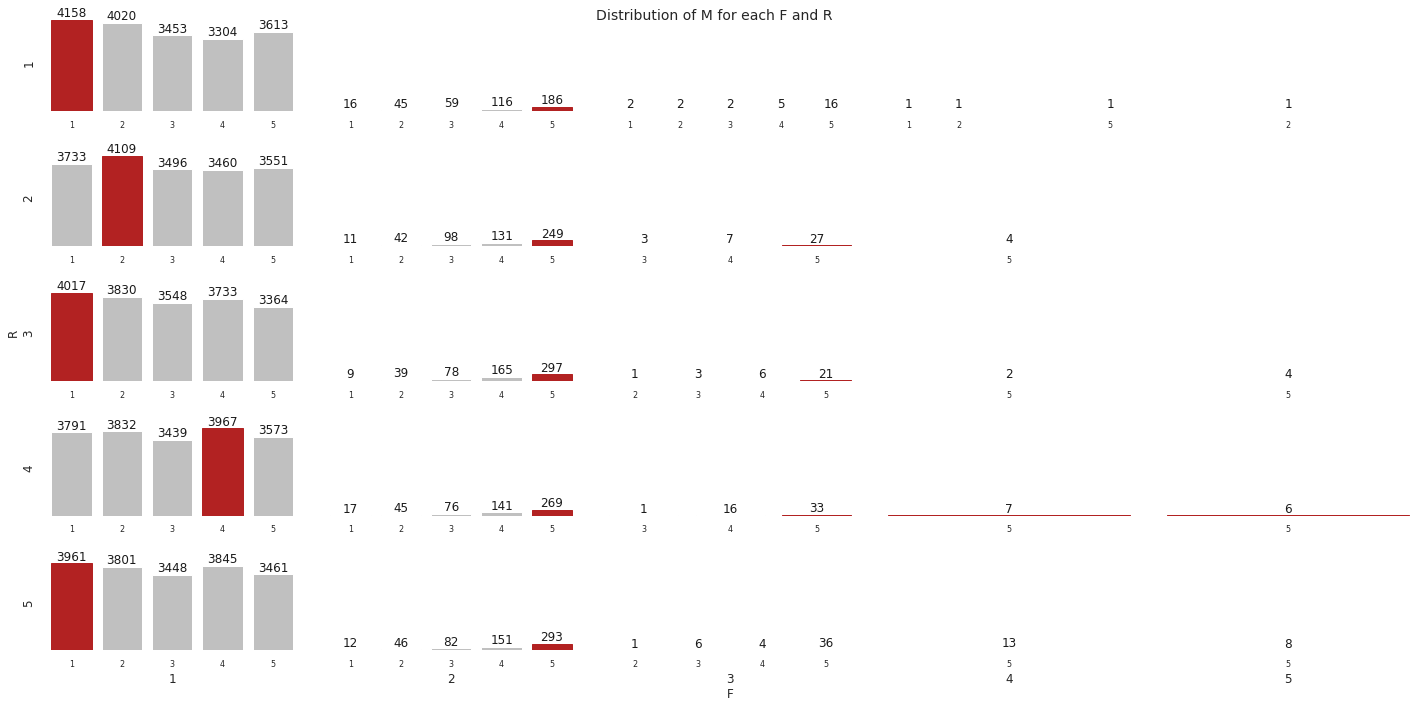

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(20, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

## Выводы:

Большинство пользователей сделали всего 1 заказ.

96% пользователей совершают одну покупку.

Почти 40% клиентов очень давно не покупали товаров, еще 20% в ближайшее время попадут в спящие.